# Packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math

from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

from scipy.stats import randint, uniform

# Exploratory Data Analysis

In [2]:
data = pd.read_csv('database.csv')
data['Date'] = pd.to_datetime(data['Date'])
data

,Date,Encoded Products,Store,Units,Day,Month,Year,Day of Week
0,2022-01-02,Producto 0,Cadereyta,0.0,2,1,2022,6
1,2022-01-02,Producto 0,Coahuila,0.0,2,1,2022,6
2,2022-01-02,Producto 0,Durango,0.0,2,1,2022,6
3,2022-01-02,Producto 0,Expos F,0.0,2,1,2022,6
4,2022-01-02,Producto 0,Laredo,0.0,2,1,2022,6
...,...,...,...,...,...,...,...,...
194975,2023-12-31,Producto 8,Monterrey,0.0,31,12,2023,6
194976,2023-12-31,Producto 8,Online,0.0,31,12,2023,6
194977,2023-12-31,Producto 8,Queretaro,0.0,31,12,2023,6
194978,2023-12-31,Producto 8,Reynosa,0.0,31,12,2023,6


<Axes: >

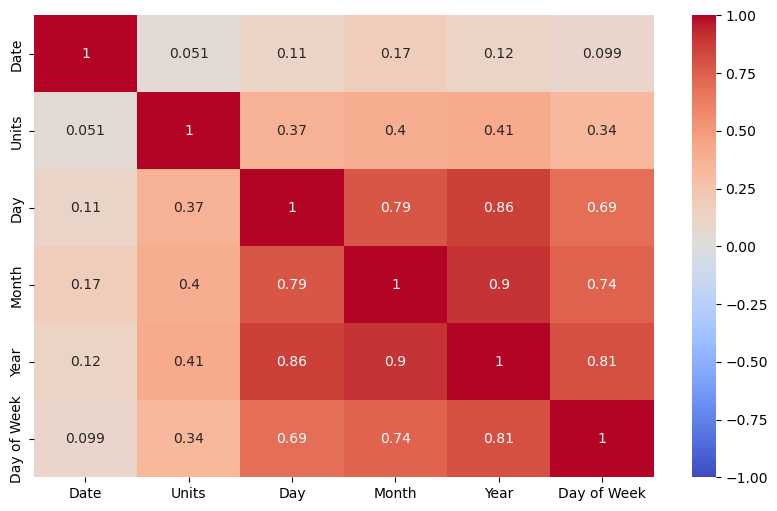

In [3]:
plt.figure(figsize=(10, 6))
sns.heatmap(
    data.select_dtypes(exclude='object').corr(), 
    cmap='coolwarm', 
    annot=True,
    vmin=-1,
    vmax=1)

In [4]:
features = ['Encoded Products', 'Store', 'Day', 'Month', 'Year', 'Day of Week', 'Date']
X = data[features]
y = data['Units']

In [5]:
def plot_time_series(product, store):
    X_temp = X[(X['Encoded Products'] == product) & (X['Store'] == store)]
    y_temp = y[(X['Encoded Products'] == product) & (X['Store'] == store)]

    plt.figure(figsize=(10, 6))
    sns.lineplot(x=X_temp['Date'], y=y_temp)
    plt.axhline(y=0, color='blue') # y = 4/3 line
    plt.title(f'Product: {product}, in Store: {store}')

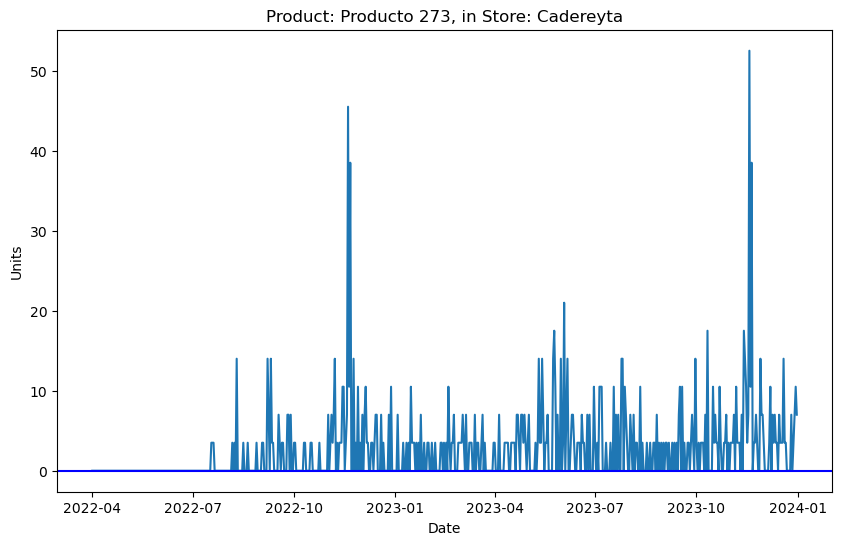

In [6]:
plot_time_series('Producto 273', 'Cadereyta')

In [7]:
grouped = data.groupby(['Encoded Products', 'Store'])['Units'].aggregate(['mean','std'])
CV2 = (grouped['std']/grouped['mean'])**2
CV2.fillna(0, inplace=True)
CV2

Encoded Products  Store    
Producto 0        Cadereyta     28.555243
                  Coahuila       1.979484
                  Durango       22.776435
                  Expos F      201.159000
                  Laredo        19.839375
                                  ...    
Producto 99       Monterrey      0.952206
                  Online         0.000000
                  Queretaro      6.176471
                  Reynosa       10.980392
                  San Luis      16.985294
Length: 2740, dtype: float64

In [8]:
grouped = data[['Encoded Products', 'Store', 'Date', 'Units']].groupby(['Encoded Products', 'Store'])
print(len(grouped.groups))
points = []

for (product, store), group in grouped:
    temp = group['Units'].aggregate(['mean','std'])
    CV2 = (temp['std']/temp['mean'])**2 
    ADI = group[group['Units'] != 0]['Date'].diff().dt.days.mean()
    if not (math.isnan(CV2) or math.isnan(ADI)):
        if ADI > 4/3 and CV2 < 0.5:
            label = 'Intermittent'
        if ADI > 4/3 and CV2 >= 0.5:
            label = 'Lumpy'
        if ADI <= 4/3 and CV2 >= 0.5:
            label = 'Erratic'
        if ADI <= 4/3 and CV2 < 0.5:
            label = 'Smooth'
        points.append({'Product': product, 'Store': store, 'CV2': CV2, 'ADI': ADI, 'Label': label})
        # print(len(group), temp['mean'], temp['std'], ADI)
    # else: print(len(group), temp['mean'], temp['std'], ADI)

points = pd.DataFrame(points)
points

2740


C:\Users\Raul\AppData\Local\Temp\ipykernel_17544\2958233400.py:7: RuntimeWarning: invalid value encountered in scalar divide
  CV2 = (temp['std']/temp['mean'])**2


,Product,Store,CV2,ADI,Label
0,Producto 0,Cadereyta,28.555243,13.862745,Lumpy
1,Producto 0,Coahuila,1.979484,1.659817,Lumpy
2,Producto 0,Durango,22.776435,17.210526,Lumpy
3,Producto 0,Expos F,201.159000,40.000000,Lumpy
4,Producto 0,Laredo,19.839375,5.204380,Lumpy
...,...,...,...,...,...
1007,Producto 99,Laredo,16.985294,232.000000,Lumpy
1008,Producto 99,Monterrey,0.952206,17.111111,Lumpy
1009,Producto 99,Queretaro,6.176471,84.750000,Lumpy
1010,Producto 99,Reynosa,10.980392,47.500000,Lumpy


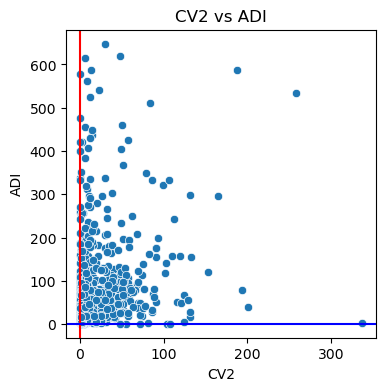

In [9]:
plt.figure(figsize=(4,4))
sns.scatterplot(x='CV2', y='ADI', data=points)
plt.axvline(x=0.5, color='red') # x = 0.5 line
plt.axhline(y=4/3, color='blue') # y = 4/3 line
plt.title('CV2 vs ADI')
plt.show()

In [10]:
points.groupby('Label').size() / len(points)

Label
Erratic         0.010870
Intermittent    0.059289
Lumpy           0.929842
dtype: float64

# Modelos Estadísticos

In [11]:
class naive():
    def __init__(self):
        pass
    def fit(self, X_train, y_train):
        self.y_train = y_train
    def predict(self, X_test):
        return [self.y_train.iloc[-1]]*len(X_test)

In [12]:
class seasonal_naive():
    def __init__(self):
        pass
    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train
    def predict(self, X_test):
        registers = len(X_test)
        y_pred = []
        for i in range(registers):
            y_pred.append(self.y_train.iloc[i%len(self.y_train)])
        return y_pred

# Aprendizaje Automático

In [13]:
class GBM():
    def __init__(self):
        self.model = GradientBoostingRegressor()

        self.scorers = {
            'accuracy': make_scorer(accuracy_score),
            'precision': make_scorer(precision_score, average='weighted', zero_division=0),
            'recall': make_scorer(recall_score, average='weighted', zero_division=0),
            'f1_weighted': make_scorer(f1_score, average='weighted', zero_division=0),
            # 'roc_auc': make_scorer(roc_auc_score, average='weighted', multi_class='ovr')
        }

        self.param_dist = {
            'n_estimators': randint(50, 500), # Number of boosting stages
            'learning_rate': uniform(0.01, 0.3), # Step size shrinkage used in update to prevent overfitting
            'max_depth': randint(3, 5), # Maximum depth of the individual estimators
            'min_samples_split': randint(2, 15), # Minimum number of samples required to split an internal node
            'min_samples_leaf': randint(1, 15) # Minimum number of samples required to be at a leaf node
            # 'max_features': ['sqrt', 'log2', None] # Number of features to consider when looking for the best split
        }

        tscv = TimeSeriesSplit(n_splits=5)


        self.random_search = RandomizedSearchCV(
            self.model,
            param_distributions=self.param_dist,
            n_iter=10,
            cv=tscv,
            scoring=self.scorers,
            refit='f1_weighted',
            verbose=10,
            random_state=42
        )

    def fit(self, X_train, y_train):
        self.random_search.fit(X_train, y_train)
        self.model.set_params(**self.random_search.best_params_)
    def predict(self, X_test):
        return self.model.predict(X_test)

# Métricas

In [14]:
def scores(model, params):
    X_train = params[0]
    y_train = params[1]
    X_test = params[2]
    y_test = params[3]

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Mean Squared Error
    MSE = ((y_test - y_pred)**2).mean()        
    
    # Root Mean Squared Squared Error
    train_mse = ((y_train - y_train.shift(1))**2).mean()
    RMSSE = np.sqrt(MSE/np.mean(train_mse))

    # Mean Absolute Error
    MAE = (np.abs(y_test - y_pred)).mean()        
    
    # Root Mean Squared Squared Error
    train_mae = (np.abs(y_train - y_train.shift(1))).mean()
    AMSE = np.sqrt(MAE/np.mean(train_mae))

    # Mean Percentage Error
    # Avoid division by zero
    MAPE = (np.abs((y_test - y_pred)/np.where(y_test==0, 1, y_test))).mean()

    print('MAPE:', MAPE)
    print('RMSSE:', RMSSE)
    print('AMSE:', AMSE)
    print('MSE:', MSE)
    print('MAE:', MAE)


# Model Testing

In [15]:
tscv = TimeSeriesSplit(n_splits=5)

for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    params = [X_train, y_train, X_test, y_test]

    print('Naive')
    scores(naive(), params)
    print()
    print('Seasonal Naive')
    scores(seasonal_naive(), params)
    print()
    print('GBM')
    scores(GBM(), params)

Naive
MAPE: 0.14906450024618415
RMSSE: 0.5042515943553615
AMSE: 0.711136642955176
MSE: 9.48002831117676
MAE: 0.845488675529296

Seasonal Naive


MAPE: 0.6467558521485747
RMSSE: 0.8124418375800693
AMSE: 0.8738040439242017
MSE: 24.609321147218118
MAE: 1.2765263417035944

GBM
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5; 1/10] START learning_rate=0.12236203565420874, max_depth=3, min_samples_leaf=11, min_samples_split=9, n_estimators=238
[CV 1/5; 1/10] END learning_rate=0.12236203565420874, max_depth=3, min_samples_leaf=11, min_samples_split=9, n_estimators=238; accuracy: (test=nan) f1_weighted: (test=nan) precision: (test=nan) recall: (test=nan) total time=   0.0s
[CV 2/5; 1/10] START learning_rate=0.12236203565420874, max_depth=3, min_samples_leaf=11, min_samples_split=9, n_estimators=238
[CV 2/5; 1/10] END learning_rate=0.12236203565420874, max_depth=3, min_samples_leaf=11, min_samples_split=9, n_estimators=238; accuracy: (test=nan) f1_weighted: (test=nan) precision: (test=nan) recall: (test=nan) total time=   0.0s
[CV 3/5; 1/10] START learning_rate=0.12236203565420874, max_depth=3, min_samples_leaf=11, 

ValueError: 
All the 50 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
50 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Raul\miniconda3\envs\ML\lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Raul\miniconda3\envs\ML\lib\site-packages\sklearn\base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Raul\miniconda3\envs\ML\lib\site-packages\sklearn\ensemble\_gb.py", line 416, in fit
    X, y = self._validate_data(
  File "c:\Users\Raul\miniconda3\envs\ML\lib\site-packages\sklearn\base.py", line 621, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "c:\Users\Raul\miniconda3\envs\ML\lib\site-packages\sklearn\utils\validation.py", line 1147, in check_X_y
    X = check_array(
  File "c:\Users\Raul\miniconda3\envs\ML\lib\site-packages\sklearn\utils\validation.py", line 917, in check_array
    array = _asarray_with_order(array, order=order, dtype=dtype, xp=xp)
  File "c:\Users\Raul\miniconda3\envs\ML\lib\site-packages\sklearn\utils\_array_api.py", line 380, in _asarray_with_order
    array = numpy.asarray(array, order=order, dtype=dtype)
  File "c:\Users\Raul\miniconda3\envs\ML\lib\site-packages\pandas\core\generic.py", line 2084, in __array__
    arr = np.asarray(values, dtype=dtype)
ValueError: could not convert string to float: 'Producto 0'
